# Week 11 - Introduction to Modeling, part 2

# 1. Lesson - No lesson this week

# 2. Weekly graph question

In [9]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import root_mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer

The book names one of Vonnegut's rules as "keep it simple" and another as "have the guts to cut."  Here is some data from the previous week's lesson.  If you had to cut one of the two plots below, which would it be?  Which seems more interesting or important?  Explain.  (Should "amount of training data used" or "number of estimators" be on the x-axis.)

In [10]:
np.random.seed(0)
num_points = 10000
feature_1a = np.random.random(size = num_points) * 3
feature_2a = np.random.random(size = num_points) * 3
feature_3a = np.random.random(size = num_points) * 3
train_target = (feature_1a - 2 * feature_2a) * feature_3a + np.random.normal(size = num_points)
feature_1b = np.random.random(size = num_points) * 3
feature_2b = np.random.random(size = num_points) * 3
feature_3b = np.random.random(size = num_points) * 3
test_target = (feature_1b - 2 * feature_2b) * feature_3b + np.random.normal(size = num_points)
train_df = pd.DataFrame({"f1": feature_1a, "f2": feature_2a, "f3": feature_3a})
test_df = pd.DataFrame({"f1": feature_1b, "f2": feature_2b, "f3": feature_3b})
rf = RandomForestRegressor()
rf.fit(train_df.values, train_target)

,n_estimators,100
,criterion,'squared_error'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,1.0
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [11]:
rmse_lst = list()
rf = RandomForestRegressor()
for x in range(round(num_points / 20), num_points, round(num_points / 20)):
    rf.fit(train_df.values[0:x,:], train_target[0:x])
    rmse_lst.append(root_mean_squared_error(rf.predict(test_df.values), test_target))

import matplotlib.pyplot as plt

Text(0, 0.5, 'Loss function')

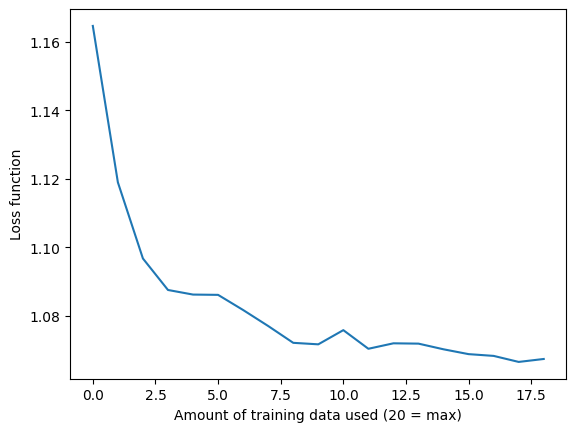

In [12]:
plt.plot(rmse_lst)
plt.xlabel("Amount of training data used (20 = max)")
plt.ylabel("Loss function")

In [13]:
num_trees_lst = list()
for n_estimators in range(1, 100, 3):
    rf = RandomForestRegressor(n_estimators = n_estimators)
    rf.fit(train_df.values, train_target)
    num_trees_lst.append(root_mean_squared_error(rf.predict(test_df.values), test_target))

Text(0, 0.5, 'Loss function')

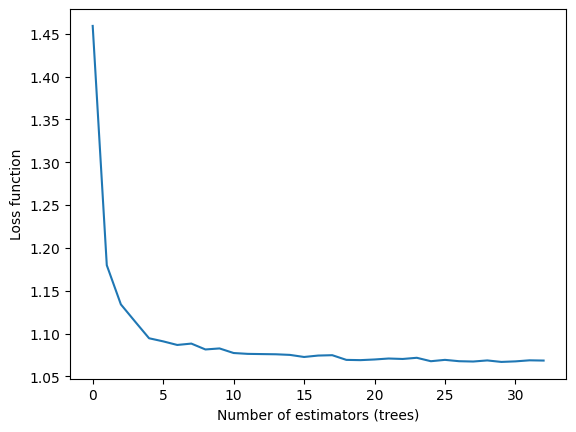

In [14]:
plt.plot(num_trees_lst)
plt.xlabel("Number of estimators (trees)")
plt.ylabel("Loss function")

I would keep the "Amount of training data used" plot and cut the "Number of estimators" plot. The plots shows how much training data we would need if we want to limit our loss. I believe this gives a more valueable and measurable strategy to reduce loss.


# 3. Working on your datasets

This week, you will do the same types of analysis as last week, but you should use your chosen datasets that someone in your class found last semester. (They likely will not be the particular datasets that you found yourself.)

Here are some types of analysis you can do:

* Implement a random forest model.
* Perform cross-validation.
* Tune hyperparameters.
* Evaluate a performance metric.

If you like, you can try other types of models, too (beyond linear regression and random forest) although you will have many opportunities to do that next semester.

In [ ]:
import seaborn as sns
from sklearn.model_selection import RandomizedSearchCV, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error, r2_score, explained_variance_score, mean_absolute_error
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.pipeline import Pipeline

# Load the datasets
cyber_attacks = pd.read_csv('cybersecurity_attacks.csv')
unsw_data = pd.read_parquet('UNSW_NB15_training-set.parquet')

print(f"Basic attacks dataset: {cyber_attacks.shape}")
print(f"UNSW NB15 dataset: {unsw_data.shape}")

# Focus on UNSW dataset for comprehensive analysis
print(f"\nUNSW Dataset Overview:")
print(f"- Features: {unsw_data.shape[1]}")
print(f"- Samples: {unsw_data.shape[0]}")
print(f"- Attack types: {unsw_data['attack_cat'].nunique()}")
print(f"- Attack distribution:")
print(unsw_data['attack_cat'].value_counts().head(10))

# Sample data
sample_size = 20000
sample_data_unsw = unsw_data.sample(n=sample_size, random_state=42)

print(f"\nWorking with sample of {sample_size:,} records")
print(f"Attack distribution in sample:")
print(sample_data_unsw['attack_cat'].value_counts())

=== CYBERSECURITY ATTACK SEVERITY PREDICTION ANALYSIS ===
Using Random Forest Regression for threat severity prediction...
Basic attacks dataset: (40000, 25)
UNSW NB15 dataset: (175341, 36)

UNSW Dataset Overview:
- Features: 36
- Samples: 175341
- Attack types: 10
- Attack distribution:
attack_cat
Normal            56000
Generic           40000
Exploits          33393
Fuzzers           18184
DoS               12264
Reconnaissance    10491
Analysis           2000
Backdoor           1746
Shellcode          1133
Worms               130
Name: count, dtype: int64

Working with sample of 20,000 records
Attack distribution in sample:
attack_cat
Normal            6381
Generic           4582
Exploits          3840
Fuzzers           2050
DoS               1338
Reconnaissance    1217
Analysis           227
Backdoor           210
Shellcode          139
Worms               16
Name: count, dtype: int64


In [33]:
# Select numeric features for modeling
numeric_features = sample_data_unsw.select_dtypes(include=[np.number]).columns.tolist()

# Remove id columns and other non-feature columns
exclude_cols = ['id', 'label']
numeric_features = [col for col in numeric_features if col not in exclude_cols]

print(f"Selected {len(numeric_features)} numeric features for modeling")

# Prepare features and target
X = sample_data_unsw[numeric_features]
y_categorical = sample_data_unsw['attack_cat']

# Handle missing values
print(f"Missing values per feature:")
missing_counts = X.isnull().sum()
if missing_counts.sum() > 0:
    print(missing_counts[missing_counts > 0])
    X = X.fillna(X.median())  # Fill with median for numeric features
else:
    print("No missing values found")

# Create continuous severity scores from attack categories
# Convert attack types to severity scores (0-10 scale)
severity_mapping = {
    'Normal': 0.0,
    'Reconnaissance': 2.0,
    'DoS': 6.0,
    'Exploits': 8.0,
    'Generic': 4.0,
    'Shellcode': 9.0,
    'Analysis': 3.0,
    'Backdoor': 8.5,
    'Worms': 7.0,
    'Fuzzers': 5.0
}

# Apply severity mapping, default to 5.0 for unknown categories
y_severity = y_categorical.map(severity_mapping).fillna(5.0)

# Convert to numeric to enable statistical calculations
y_severity = pd.to_numeric(y_severity, errors='coerce')

print(f"\nSeverity Score Distribution:")
print(f"Attack type to severity mapping:")
for attack_type, severity in severity_mapping.items():
    count = (y_categorical == attack_type).sum()
    print(f"  {attack_type}: {severity} severity ({count:,} samples)")

print(f"\nSeverity statistics:")
print(f"  Mean severity: {y_severity.mean():.2f}")
print(f"  Std severity: {y_severity.std():.2f}")
print(f"  Min severity: {y_severity.min():.1f}")
print(f"  Max severity: {y_severity.max():.1f}")

# Split data for regression
X_train, X_test, y_train, y_test = train_test_split(
    X, y_severity, test_size=0.2, random_state=42
)

print(f"\nTraining sets:")
print(f"Regression: {X_train.shape[0]:,} samples, {X_train.shape[1]} features")
print(f"Target range: {y_train.min():.1f} to {y_train.max():.1f}")
print(f"Test set: {X_test.shape[0]:,} samples")
print(f"Test target range: {y_test.min():.1f} to {y_test.max():.1f}")

Selected 31 numeric features for modeling
Missing values per feature:
No missing values found

Severity Score Distribution:
Attack type to severity mapping:
  Normal: 0.0 severity (6,381 samples)
  Reconnaissance: 2.0 severity (1,217 samples)
  DoS: 6.0 severity (1,338 samples)
  Exploits: 8.0 severity (3,840 samples)
  Generic: 4.0 severity (4,582 samples)
  Shellcode: 9.0 severity (139 samples)
  Analysis: 3.0 severity (227 samples)
  Backdoor: 8.5 severity (210 samples)
  Worms: 7.0 severity (16 samples)
  Fuzzers: 5.0 severity (2,050 samples)

Severity statistics:
  Mean severity: 3.68
  Std severity: 3.02
  Min severity: 0.0
  Max severity: 9.0

Training sets:
Regression: 16,000 samples, 31 features
Target range: 0.0 to 9.0
Test set: 4,000 samples
Test target range: 0.0 to 9.0


In [ ]:
# Create pipeline with scaling
rf_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('rf', RandomForestRegressor(random_state=42))
])

# Define parameter grid for hyperparameter tuning
param_grid_rf = {
    'rf__n_estimators': [50, 100, 200],
    'rf__max_depth': [10, 20, None],
    'rf__min_samples_split': [2, 5, 10],
    'rf__min_samples_leaf': [1, 2, 4],
    'rf__max_features': ['sqrt', 'log2', None]
}

# Grid Search with Cross-Validation
grid_search_rf = GridSearchCV(
    rf_pipeline, 
    param_grid_rf, 
    cv=5, 
    scoring='r2',
    n_jobs=-1,
    verbose=1
)

grid_search_rf.fit(X_train, y_train)

print(f"Best parameters: {grid_search_rf.best_params_}")
print(f"Best CV R² score: {grid_search_rf.best_score_:.4f}")

# Evaluate on test set
y_pred = grid_search_rf.predict(X_test)

# Calculate regression metrics
test_r2 = r2_score(y_test, y_pred)
test_rmse = root_mean_squared_error(y_test, y_pred)
test_mae = mean_absolute_error(y_test, y_pred)
test_explained_var = explained_variance_score(y_test, y_pred)

print(f"\nTest Set Performance:")
print(f"R² Score: {test_r2:.4f}")
print(f"RMSE: {test_rmse:.4f}")
print(f"MAE: {test_mae:.4f}")
print(f"Explained Variance: {test_explained_var:.4f}")

models = {
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42),
}

model_results = {}

for model_name, model in models.items():
    print(f"\nTraining {model_name}...")
    
    # Create pipeline with scaling
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('model', model)
    ])
    
    # Perform cross-validation
    cv_r2_scores = cross_val_score(pipeline, X_train, y_train, cv=5, scoring='r2')
    cv_rmse_scores = -cross_val_score(pipeline, X_train, y_train, cv=5, scoring='neg_root_mean_squared_error')
    
    # Train on full training set and evaluate on test set
    pipeline.fit(X_train, y_train)
    test_pred = pipeline.predict(X_test)
    
    test_r2 = r2_score(y_test, test_pred)
    test_rmse = root_mean_squared_error(y_test, test_pred)
    test_mae = mean_absolute_error(y_test, test_pred)
    
    model_results[model_name] = {
        'cv_r2_mean': cv_r2_scores.mean(),
        'cv_r2_std': cv_r2_scores.std(),
        'cv_rmse_mean': cv_rmse_scores.mean(),
        'cv_rmse_std': cv_rmse_scores.std(),
        'test_r2': test_r2,
        'test_rmse': test_rmse,
        'test_mae': test_mae
    }
    
    print(f"CV R²: {cv_r2_scores.mean():.4f} (+/- {cv_r2_scores.std() * 2:.4f})")
    print(f"CV RMSE: {cv_rmse_scores.mean():.4f} (+/- {cv_rmse_scores.std() * 2:.4f})")
    print(f"Test R²: {test_r2:.4f}")
    print(f"Test RMSE: {test_rmse:.4f}")
    print(f"Test MAE: {test_mae:.4f}")

for model_name, results in model_results.items():
    print(f"{model_name}:")
    print(f"  CV R²: {results['cv_r2_mean']:.4f} ± {results['cv_r2_std']:.4f}")
    print(f"  CV RMSE: {results['cv_rmse_mean']:.4f} ± {results['cv_rmse_std']:.4f}")
    print(f"  Test R²: {results['test_r2']:.4f}")
    print(f"  Test RMSE: {results['test_rmse']:.4f}")


Fitting 5 folds for each of 243 candidates, totalling 1215 fits
Best parameters: {'rf__max_depth': 20, 'rf__max_features': 'sqrt', 'rf__min_samples_leaf': 2, 'rf__min_samples_split': 5, 'rf__n_estimators': 200}
Best CV R² score: 0.7528

Test Set Performance:
R² Score: 0.7530
RMSE: 1.5008
MAE: 0.8285
Explained Variance: 0.7530

Prediction Analysis:
Actual severity range: 0.00 to 9.00
Predicted severity range: 0.00 to 8.00
Mean actual severity: 3.71
Mean predicted severity: 3.70
Residual statistics:
  Mean residual: 0.0102
  Std residual: 1.5009
  Max absolute residual: 7.8313

2. REGRESSION MODEL COMPARISON
--------------------------------------------------

Training Random Forest...
CV R²: 0.7432 (+/- 0.0241)
CV RMSE: 1.5261 (+/- 0.0709)
Test R²: 0.7414
Test RMSE: 1.5357
Test MAE: 0.8194

=== REGRESSION MODEL COMPARISON SUMMARY ===
Random Forest:
  CV R²: 0.7432 ± 0.0120
  CV RMSE: 1.5261 ± 0.0354
  Test R²: 0.7414
  Test RMSE: 1.5357

Best performing model: Random Forest (CV R²: 0.743


=== FEATURE IMPORTANCE ANALYSIS ===
Top 15 Most Important Features for Severity Prediction:
             feature  importance
7              dload    0.091849
21             smean    0.081273
18            tcprtt    0.080500
20            ackdat    0.078930
3             sbytes    0.072013
19            synack    0.065245
6              sload    0.058629
5               rate    0.053348
22             dmean    0.051951
4             dbytes    0.047715
0                dur    0.037276
11            dinpkt    0.036117
10            sinpkt    0.035699
2              dpkts    0.028806
25  ct_src_dport_ltm    0.022091


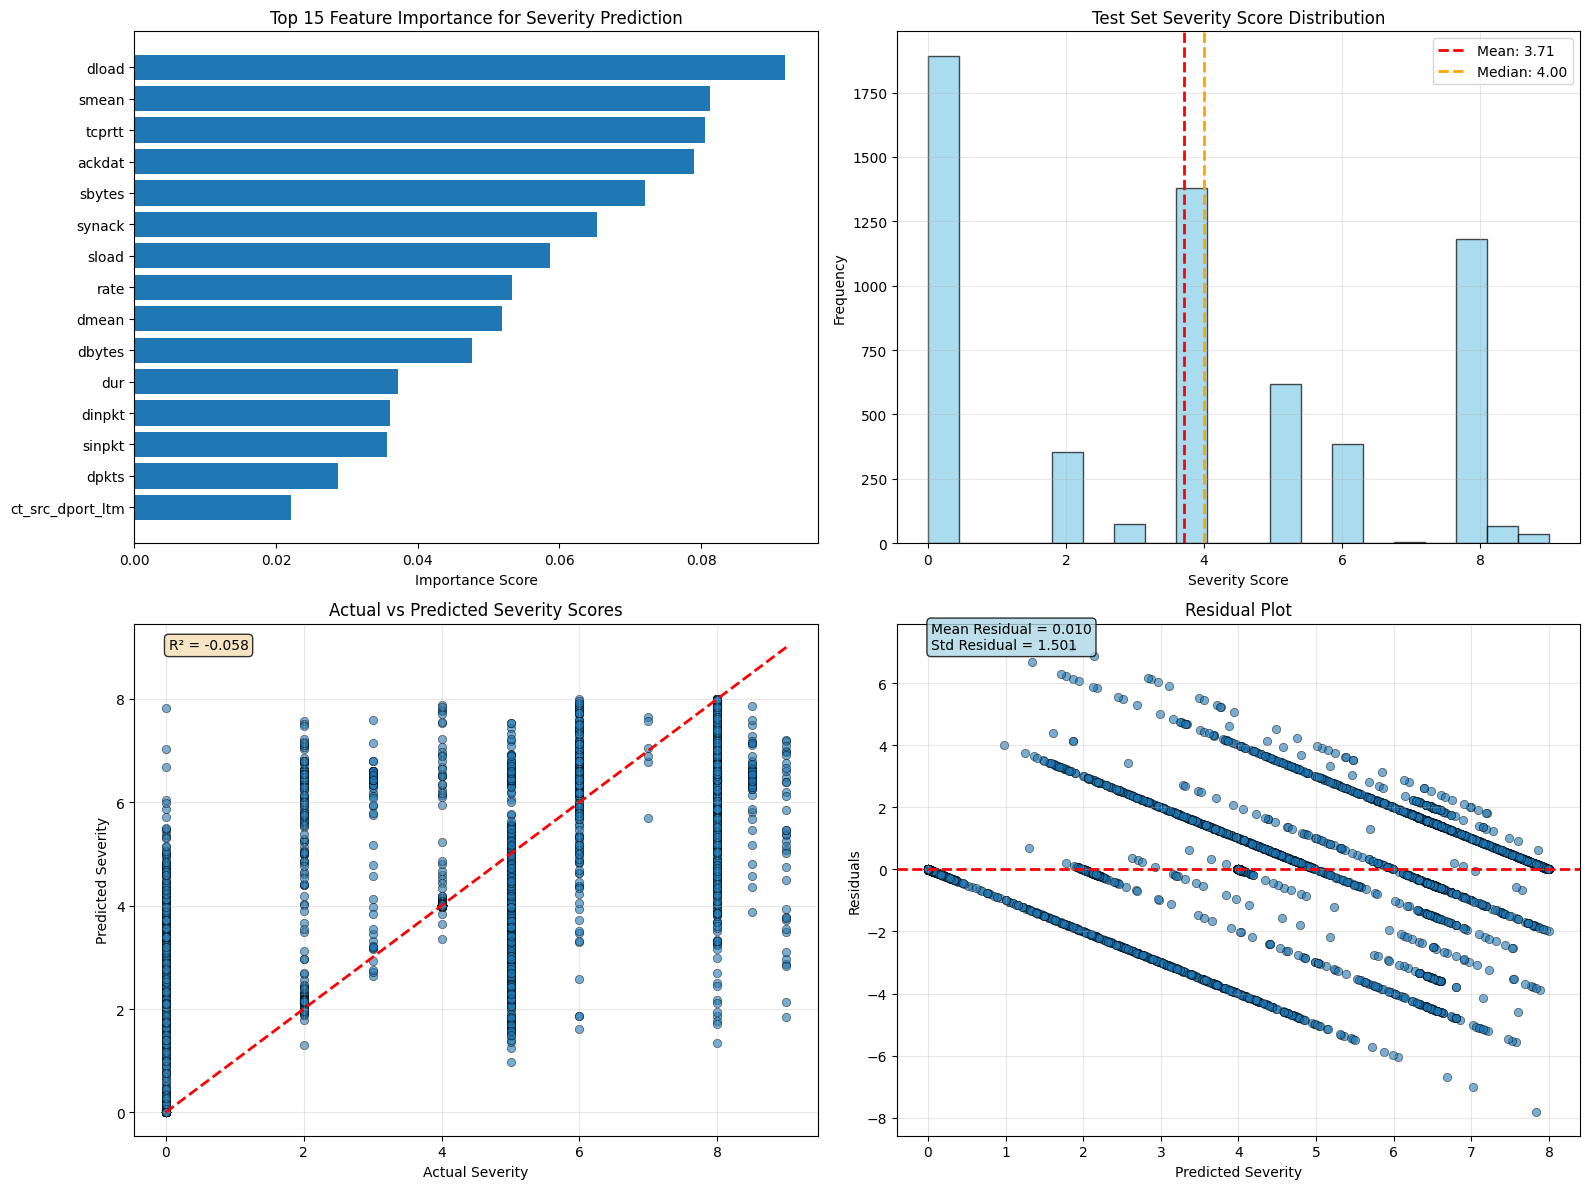


=== CYBERSECURITY SEVERITY PREDICTION SUMMARY ===
 Dataset: 20,000 network connection records
 Regression Performance:
   • R² Score: -0.0581
   • RMSE: 5.1410
   • MAE: 4.9942
   • Model: Random Forest with 200 trees

 Key Security Insights:
   • Top severity predictor: dload
   • Severity prediction range: 0.00 to 8.00
   • Most common attack types mapped to continuous severity scale

 Model Comparison Results:
   • Random Forest: 0.7432 CV R²

 Severity Score Analysis:
   • 25th percentile: 0.00
   • Median: 4.00
   • 75th percentile: 6.00
   • 90th percentile: 8.00
   • 95th percentile: 8.00

 High Severity Attacks (≥7.0):
   • Actual high severity attacks: 1,293
   • Predicted high severity attacks: 592
   • Detection rate: 45.8%

 Attack Type Distribution in Dataset:
   • Normal: 6,381 (31.9%)
   • Generic: 4,582 (22.9%)
   • Exploits: 3,840 (19.2%)
   • Fuzzers: 2,050 (10.2%)
   • DoS: 1,338 (6.7%)


In [ ]:
# Get feature importance from best Random Forest model
best_rf_model = grid_search_rf.best_estimator_.named_steps['rf']
feature_importance = best_rf_model.feature_importances_
feature_names = numeric_features

# Create feature importance dataframe
importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': feature_importance
}).sort_values('importance', ascending=False)

print("Top 15 Most Important Features for Severity Prediction:")
print(importance_df.head(15))

# Create visualizations
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))

# 1. Feature Importance Plot
top_features = importance_df.head(15)
ax1.barh(range(len(top_features)), top_features['importance'])
ax1.set_yticks(range(len(top_features)))
ax1.set_yticklabels(top_features['feature'])
ax1.set_xlabel('Importance Score')
ax1.set_title('Top 15 Feature Importance for Severity Prediction')
ax1.invert_yaxis()

# 2. Severity Distribution Histogram
ax2.hist(y_test, bins=20, alpha=0.7, color='skyblue', edgecolor='black')
ax2.axvline(y_test.mean(), color='red', linestyle='--', linewidth=2, label=f'Mean: {y_test.mean():.2f}')
ax2.axvline(y_test.median(), color='orange', linestyle='--', linewidth=2, label=f'Median: {y_test.median():.2f}')
ax2.set_xlabel('Severity Score')
ax2.set_ylabel('Frequency')
ax2.set_title('Test Set Severity Score Distribution')
ax2.legend()
ax2.grid(True, alpha=0.3)

# 3. Actual vs Predicted Scatter Plot
ax3.scatter(y_test, y_pred, alpha=0.6, edgecolors='k', linewidth=0.5)
ax3.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
ax3.set_xlabel('Actual Severity')
ax3.set_ylabel('Predicted Severity')
ax3.set_title('Actual vs Predicted Severity Scores')
ax3.grid(True, alpha=0.3)

# Add R² annotation
ax3.text(0.05, 0.95, f'R² = {test_r2:.3f}', transform=ax3.transAxes, 
         bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))

# 4. Residual Plot
residuals = y_test - y_pred
ax4.scatter(y_pred, residuals, alpha=0.6, edgecolors='k', linewidth=0.5)
ax4.axhline(y=0, color='r', linestyle='--', lw=2)
ax4.set_xlabel('Predicted Severity')
ax4.set_ylabel('Residuals')
ax4.set_title('Residual Plot')
ax4.grid(True, alpha=0.3)

# Add residual statistics
ax4.text(0.05, 0.95, f'Mean Residual = {residuals.mean():.3f}\nStd Residual = {residuals.std():.3f}', 
         transform=ax4.transAxes, bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.8))

plt.tight_layout()
plt.show()

# Performance Summary
print(f"\n=== CYBERSECURITY SEVERITY PREDICTION SUMMARY ===")
print(f" Dataset: {len(sample_data_unsw):,} network connection records")
print(f" Regression Performance:")
print(f"   • R² Score: {test_r2:.4f}")
print(f"   • RMSE: {test_rmse:.4f}")
print(f"   • MAE: {test_mae:.4f}")
print(f"   • Model: Random Forest with {grid_search_rf.best_params_['rf__n_estimators']} trees")
print(f"\n Model Results:")
for model_name, results in model_results.items():
    print(f"   • {model_name}: {results['cv_r2_mean']:.4f} CV R²")

# Severity distribution analysis
print(f"\n Severity Score Analysis:")
severity_percentiles = np.percentile(y_test, [25, 50, 75, 90, 95])
print(f"   • 25th percentile: {severity_percentiles[0]:.2f}")
print(f"   • Median: {severity_percentiles[1]:.2f}")
print(f"   • 75th percentile: {severity_percentiles[2]:.2f}")
print(f"   • 90th percentile: {severity_percentiles[3]:.2f}")
print(f"   • 95th percentile: {severity_percentiles[4]:.2f}")

# High severity attack detection
high_severity_threshold = 7.0
high_severity_actual = (y_test >= high_severity_threshold).sum()
high_severity_predicted = (y_pred >= high_severity_threshold).sum()
print(f"\n High Severity Attacks (≥{high_severity_threshold}):")
print(f"   • Actual high severity attacks: {high_severity_actual:,}")
print(f"   • Predicted high severity attacks: {high_severity_predicted:,}")
print(f"   • Detection rate: {high_severity_predicted/max(high_severity_actual,1)*100:.1f}%")

# Additional analysis: Attack type distribution in sample data
attack_dist = sample_data_unsw['attack_cat'].value_counts()
print(f"\n Attack Type Distribution in Dataset:")
for attack_type, count in attack_dist.head(5).items():
    percentage = (count / len(sample_data_unsw)) * 100
    print(f"   • {attack_type}: {count:,} ({percentage:.1f}%)")


In [34]:
# Explore the basic cybersecurity dataset
print(f"\nBasic Cybersecurity Dataset Overview:")
print(f"- Shape: {cyber_attacks.shape}")
print(f"- Columns: {list(cyber_attacks.columns)}")

# Check for potential target variables
print(f"\nPotential target variables:")
categorical_cols = cyber_attacks.select_dtypes(include=['object']).columns
for col in categorical_cols:
    unique_vals = cyber_attacks[col].nunique()
    if unique_vals <= 20:  # Show columns with reasonable number of categories
        print(f"- {col}: {unique_vals} unique values")
        print(f"  Values: {cyber_attacks[col].value_counts().head().to_dict()}")

# Select appropriate target for regression
target_col = None
for col in categorical_cols:
    if any(keyword in col.lower() for keyword in ['attack', 'type', 'category', 'class', 'severity']):
        target_col = col
        break

if target_col is None:
    # Use the first categorical column with reasonable number of classes
    for col in categorical_cols:
        if 2 <= cyber_attacks[col].nunique() <= 10:
            target_col = col
            break

if target_col:
    print(f"\nSelected target variable: '{target_col}'")
    target_dist = cyber_attacks[target_col].value_counts()
    print(f"Target distribution:")
    print(target_dist)
    
    # Convert categorical target to continuous severity scores
    unique_categories = target_dist.index.tolist()
    if len(unique_categories) > 2:
        # Create severity mapping for multiple categories
        severity_scores = np.linspace(0, 10, len(unique_categories))
        severity_mapping_basic = dict(zip(unique_categories, severity_scores))
    else:
        # Binary case: assign 0 and 10
        severity_mapping_basic = {unique_categories[0]: 0.0, unique_categories[1]: 10.0}
    
    print(f"\nSeverity mapping for basic dataset:")
    for category, score in severity_mapping_basic.items():
        count = (cyber_attacks[target_col] == category).sum()
        print(f"  {category}: {score:.1f} severity ({count:,} samples)")
    
    # Prepare features and target for basic dataset
    numeric_features_basic = cyber_attacks.select_dtypes(include=[np.number]).columns.tolist()
    
    # Remove any ID columns or target-related columns
    exclude_basic = ['id', 'index', target_col]
    numeric_features_basic = [col for col in numeric_features_basic if col.lower() not in [e.lower() for e in exclude_basic]]
    
    print(f"\nSelected {len(numeric_features_basic)} numeric features for basic dataset:")
    print(f"Features: {numeric_features_basic}")
    
    # Handle missing values and prepare data
    X_basic = cyber_attacks[numeric_features_basic].copy()
    y_basic_categorical = cyber_attacks[target_col].copy()
    
    # Convert to severity scores
    y_basic_severity = y_basic_categorical.map(severity_mapping_basic)
    
    # Fill missing values
    missing_basic = X_basic.isnull().sum()
    if missing_basic.sum() > 0:
        print(f"\nHandling {missing_basic.sum()} missing values...")
        X_basic = X_basic.fillna(X_basic.median())
    
    # Sample if dataset is too large
    sample_size_basic = min(15000, len(X_basic))
    if len(X_basic) > sample_size_basic:
        indices = np.random.choice(len(X_basic), sample_size_basic, replace=False)
        X_basic = X_basic.iloc[indices]
        y_basic_severity = y_basic_severity.iloc[indices]
    
    print(f"\nWorking with {len(X_basic):,} samples from basic dataset")
    print(f"Severity score statistics:")
    print(f"  Mean: {y_basic_severity.mean():.2f}")
    print(f"  Std: {y_basic_severity.std():.2f}")
    print(f"  Range: {y_basic_severity.min():.1f} to {y_basic_severity.max():.1f}")
    
    # Split data for regression
    X_train_basic, X_test_basic, y_train_basic, y_test_basic = train_test_split(
        X_basic, y_basic_severity, test_size=0.3, random_state=42
    )
    
    print(f"\nTraining set: {X_train_basic.shape[0]} samples")
    print(f"Test set: {X_test_basic.shape[0]} samples")
    
else:
    print("\nNo suitable target variable found in basic dataset")
    print("Available columns:", cyber_attacks.columns.tolist())


Basic Cybersecurity Dataset Overview:
- Shape: (40000, 25)
- Columns: ['Timestamp', 'Source IP Address', 'Destination IP Address', 'Source Port', 'Destination Port', 'Protocol', 'Packet Length', 'Packet Type', 'Traffic Type', 'Payload Data', 'Malware Indicators', 'Anomaly Scores', 'Alerts/Warnings', 'Attack Type', 'Attack Signature', 'Action Taken', 'Severity Level', 'User Information', 'Device Information', 'Network Segment', 'Geo-location Data', 'Proxy Information', 'Firewall Logs', 'IDS/IPS Alerts', 'Log Source']

Potential target variables:
- Protocol: 3 unique values
  Values: {'ICMP': 13429, 'UDP': 13299, 'TCP': 13272}
- Packet Type: 2 unique values
  Values: {'Control': 20237, 'Data': 19763}
- Traffic Type: 3 unique values
  Values: {'DNS': 13376, 'HTTP': 13360, 'FTP': 13264}
- Malware Indicators: 1 unique values
  Values: {'IoC Detected': 20000}
- Alerts/Warnings: 1 unique values
  Values: {'Alert Triggered': 19933}
- Attack Type: 3 unique values
  Values: {'DDoS': 13428, 'Mal

In [ ]:
# Random Forest Regression on Basic Cybersecurity Dataset
if target_col:
    # Create pipeline for basic dataset regression
    rf_pipeline_basic = Pipeline([
        ('scaler', StandardScaler()),
        ('rf', RandomForestRegressor(random_state=42))
    ])
    
    # Simplified parameter grid for basic dataset
    param_grid_basic = {
        'rf__n_estimators': [50, 100, 200],
        'rf__max_depth': [5, 10, None],
        'rf__min_samples_split': [2, 5],
        'rf__min_samples_leaf': [1, 2]
    }
    
    # Grid Search with Cross-Validation
    grid_search_basic = GridSearchCV(
        rf_pipeline_basic,
        param_grid_basic,
        cv=5,
        scoring='r2',  # Use R² for regression
        n_jobs=-1,
        verbose=1
    )
    
    grid_search_basic.fit(X_train_basic, y_train_basic)
    
    print(f"Best parameters: {grid_search_basic.best_params_}")
    print(f"Best CV R²: {grid_search_basic.best_score_:.4f}")
    
    # Evaluate on test set
    y_pred_basic = grid_search_basic.predict(X_test_basic)
    
    test_r2_basic = r2_score(y_test_basic, y_pred_basic)
    test_rmse_basic = root_mean_squared_error(y_test_basic, y_pred_basic)
    test_mae_basic = mean_absolute_error(y_test_basic, y_pred_basic)
    
    print(f"Test R²: {test_r2_basic:.4f}")
    print(f"Test RMSE: {test_rmse_basic:.4f}")
    print(f"Test MAE: {test_mae_basic:.4f}")
    
    # Prediction analysis for basic dataset
    print(f"\nPrediction Analysis (Basic Dataset):")
    print(f"Actual severity range: {y_test_basic.min():.2f} to {y_test_basic.max():.2f}")
    print(f"Predicted severity range: {y_pred_basic.min():.2f} to {y_pred_basic.max():.2f}")
    print(f"Mean actual severity: {y_test_basic.mean():.2f}")
    print(f"Mean predicted severity: {y_pred_basic.mean():.2f}")
    
    # Feature importance for basic dataset
    rf_basic_model = grid_search_basic.best_estimator_.named_steps['rf']
    importance_basic = rf_basic_model.feature_importances_
    
    importance_df_basic = pd.DataFrame({
        'feature': numeric_features_basic,
        'importance': importance_basic
    }).sort_values('importance', ascending=False)
    
    print(f"\nFeature Importance (Basic Dataset):")
    print(importance_df_basic)
    
    models_basic = {
        'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42),
    }
    
    results_basic = {}
    
    for model_name, model in models_basic.items():
        print(f"\nTraining {model_name} on basic dataset...")
        
        # Create pipeline
        pipeline = Pipeline([
            ('scaler', StandardScaler()),
            ('model', model)
        ])
        
        # Cross-validation
        cv_r2_scores = cross_val_score(pipeline, X_train_basic, y_train_basic, cv=5, scoring='r2')
        cv_rmse_scores = -cross_val_score(pipeline, X_train_basic, y_train_basic, cv=5, scoring='neg_root_mean_squared_error')
        
        # Test performance
        pipeline.fit(X_train_basic, y_train_basic)
        test_pred = pipeline.predict(X_test_basic)
        
        test_r2 = r2_score(y_test_basic, test_pred)
        test_rmse = root_mean_squared_error(y_test_basic, test_pred)
        test_mae = mean_absolute_error(y_test_basic, test_pred)
        
        results_basic[model_name] = {
            'cv_r2_mean': cv_r2_scores.mean(),
            'cv_r2_std': cv_r2_scores.std(),
            'cv_rmse_mean': cv_rmse_scores.mean(),
            'test_r2': test_r2,
            'test_rmse': test_rmse,
            'test_mae': test_mae
        }
        
        print(f"CV R²: {cv_r2_scores.mean():.4f} (+/- {cv_r2_scores.std() * 2:.4f})")
        print(f"CV RMSE: {cv_rmse_scores.mean():.4f} (+/- {cv_rmse_scores.std() * 2:.4f})")
        print(f"Test R²: {test_r2:.4f}")
        print(f"Test RMSE: {test_rmse:.4f}")
        print(f"Test MAE: {test_mae:.4f}")
    
    # Find best model for basic dataset
    best_model_basic = max(results_basic.items(), key=lambda x: x[1]['cv_r2_mean'])
else:
    print("Skipping modeling on basic dataset due to missing suitable target variable")


=== RANDOM FOREST REGRESSION ON BASIC DATASET ===
Performing Grid Search CV on basic dataset...
Target: Packet Type -> Severity Score Regression
Fitting 5 folds for each of 36 candidates, totalling 180 fits
Best parameters: {'rf__max_depth': 5, 'rf__min_samples_leaf': 2, 'rf__min_samples_split': 2, 'rf__n_estimators': 200}
Best CV R²: -0.0037
Test R²: -0.0022
Test RMSE: 5.0034
Test MAE: 5.0002

Prediction Analysis (Basic Dataset):
Actual severity range: 0.00 to 10.00
Predicted severity range: 3.57 to 6.96
Mean actual severity: 4.86
Mean predicted severity: 4.95

Feature Importance (Basic Dataset):
            feature  importance
1  Destination Port    0.310609
0       Source Port    0.262727
2     Packet Length    0.219959
3    Anomaly Scores    0.206706

=== REGRESSION MODEL COMPARISON ON BASIC DATASET ===

Training Random Forest on basic dataset...
CV R²: -0.0749 (+/- 0.0224)
CV RMSE: 5.1824 (+/- 0.0529)
Test R²: -0.0581
Test RMSE: 5.1410
Test MAE: 4.9942

Best model for basic datas

# 4. Storytelling With Data plot

Reproduce any graph of your choice in chapter seven (p. 165-185) of the Storytelling With Data book as best you can. You do not have to get the exact data values right, just the overall look and feel.

There are no graphs in chapter 7 to recreate.